# lorapy symbol viewer

In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import os, sys
from loguru import logger
logger.remove(None)
logger.add(sys.stdout, colorize=True)

import numpy as np
import pandas as pd
from six.moves import cPickle
import tqdm
from tqdm import tqdm_notebook
import warnings 
import scipy.signal as spsig
import multiprocessing
from functools import partial 

import matplotlib.pyplot as plt 
# plt.style.use('dark_background')
%matplotlib inline

In [2]:
import lorapy

## setup 

In [8]:
_BASE_DATA_DIR = pathlib.Path('../data')

BENCHTOP_DATA_DIR = _BASE_DATA_DIR.joinpath('lora-benchtop-recording')
DOTP_DATA_DIR = _BASE_DATA_DIR.joinpath('symbol-ref')
DEV_DATA_DIR = _BASE_DATA_DIR.joinpath('dev-data')
PROC_SYMBOL_DIR = _BASE_DATA_DIR.joinpath('processed-symbols')
PROC_OTA_SYMBOL_DIR = _BASE_DATA_DIR.joinpath('processed-symbols/ota')
FILT_SYMBOL_DIR = _BASE_DATA_DIR.joinpath('filtered-symbols')
OTA_FILT_SYMBOL_DIR = _BASE_DATA_DIR.joinpath('filtered-symbols/ota')

# load

In [4]:
import random
import warnings 

rand = lambda mx: random.randint(0, mx - 1)

def _load_matching_dotp(bw: int, sf: int):
    return ploader.filter(bw=bw, sf=sf)[0]


def _plot_check(filtered_syms, num=20):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        fig, ax = plt.subplots(num, figsize=(14, 10))

        for idx in range(num):
            ax[idx].plot(filtered_syms[rand(filtered_syms.shape[0])])
            
            
def _format_output_path(out_dir, file):    
    out_path = out_dir.joinpath(file.name)
    return out_path


def _save_symbols(data, out_dir, file):
    out_path = _format_output_path(out_dir, file)
    
    with out_path.open('wb') as outfile:
        cPickle.dump(data, outfile)

## files

In [11]:
symloader = lorapy.load_dotp(PROC_OTA_SYMBOL_DIR, glob_pattern='**/*_d[2345].p')
symloader.file_list

2020-04-14 15:47:24.731 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: ../data/processed-symbols/ota
2020-04-14 15:47:24.736 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 60 data file(s)


[DotPFile(id=0 | name='lora_BW7_SF12_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=1 | name='lora_BW8_SF10_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=2 | name='lora_BW8_SF11_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=3 | name='lora_BW9_SF10_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=4 | name='lora_BW9_SF11_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=5 | name='lora_BW9_SF12_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=6 | name='lora_BW1_SF12_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=7 | name='lora_BW1_SF11_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=8 | name='lora_BW1_SF10_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=9 | name='lora_BW7_SF10_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=10 | name='lora_BW2_SF12_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=11 | name='lora_BW8_SF12_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=12 | name='lora_BW7_SF11_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=13 | name='lora_BW2_SF11_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=14 | name='lora_BW2_SF10_915MHz_20ksps_Att0_d5.p'),
 DotPFile(id=15 | name='lora_BW8_SF

In [6]:
ploader = lorapy.load_dotp(DOTP_DATA_DIR)
ploader.file_list

2020-04-14 15:42:07.457 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: ../data/symbol-ref
2020-04-14 15:42:07.459 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 15 data file(s)


[DotPFile(id=0 | name='lora_BW1_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=1 | name='lora_BW1_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=2 | name='lora_BW9_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=3 | name='lora_BW2_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=4 | name='lora_BW9_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=5 | name='lora_BW2_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=6 | name='lora_BW8_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=7 | name='lora_BW7_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=8 | name='lora_BW8_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=9 | name='lora_BW8_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=10 | name='lora_BW1_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=11 | name='lora_BW2_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=12 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=13 | name='lora_BW7_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=14 | name='lora_BW7_SF11_915MHz_20ksps_Att0_v0.p')]

## missing files

## new files

## symbols

# symbol filtering

In [7]:
def _fft_convolve_autocorr(symbol: np.ndarray):
    return spsig.fftconvolve(symbol, symbol[::-1], mode='full')

def _sp_corr(base_symbol: np.ndarray, packet_slice: np.ndarray) -> float:
    min_size = np.min((base_symbol.size, packet_slice.size))
    corr = spsig.correlate(base_symbol, packet_slice)
    return np.abs(corr.max())
    
def _compute_corr(symbol: np.ndarray, base_symbol: np.ndarray) -> float:
    return _sp_corr(base_symbol, _fft_convolve_autocorr(symbol))

def _mp_compute_corr(base_sym: np.ndarray, symbols: np.ndarray) -> np.ndarray:
    logger.warning(f'beginning multiprocessing..')
    _part_compute_corr = partial(_compute_corr, base_symbol=base_sym)    

    with multiprocessing.Pool() as pool:
        results = pool.map(_part_compute_corr, symbols)
    
    logger.warning(f'completed multiprocessing')
    return np.array(results)
    

def filter_symbols_fftcorr(file, thresh_adj=0.4, mp=True, plot=False):
    symbols = file.to_signal()
    display(symbols)

    pfile = _load_matching_dotp(file.bw, file.sf)
    base_symbol = pfile.to_signal()
    display(base_symbol)
    
    if mp:
        corr_fftconvs = _mp_compute_corr(base_symbol.data, symbols.data)
    else:    
        corr_fftconvs = np.array([
            _compute_corr(sym, base_symbol.data)
            for sym in symbols.data
        ])
    
    thresh = corr_fftconvs.mean() 
    thresh *= thresh_adj
    logger.info(f'set threshold: {thresh:0.6f}')
    
    filtered_symbols = symbols.data[np.where(corr_fftconvs > thresh)[0], :]
    _rm_symbols = symbols.data[np.where(corr_fftconvs < thresh)[0], :]
   
    _removed_syms = symbols.data.shape[0] - len(filtered_symbols)
    logger.warning(f'removed {_removed_syms} symbols  [{len(filtered_symbols)} / {symbols.data.shape[0]}]')
    
    if plot:
        _plot_check(filtered_symbols, 40)
        
#     return filtered_symbols, _rm_symbols, corr_fftconvs
    return filtered_symbols


In [13]:
THRESH_ADJ = 0.4


for file in tqdm.tqdm(symloader.file_list):
# for file in tqdm.tqdm(file for file in symloader.file_list if file.name in new_filenames):
    logger.warning(f'working file {file}')
    file.load()
    if file.bw > 6 and file.att > 100:
        continue
    
    filtered_symbols = filter_symbols_fftcorr(file, thresh_adj=THRESH_ADJ, mp=True, plot=False)
    _save_symbols(filtered_symbols, OTA_FILT_SYMBOL_DIR, file)
    

  0%|          | 0/60 [00:00<?, ?it/s]

2020-04-14 15:49:57.359 | WARNING  | __main__:<module>:6 - working file DotPFile(id=0 | name='lora_BW7_SF12_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:49:57.360 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 6386 and packet length: 193176
2020-04-14 15:49:57.616 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7471620 samples from file


BaselineSymbolSet(num symbols=1170 | BW: 7 | SF: 12 | Att: 0 | samples per symbol: 6386 | packet length: 193176)

2020-04-14 15:49:57.619 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 6386 and packet length: 193176
2020-04-14 15:49:57.620 | INFO     | lorapy.datafile._base_file:load:61 - loaded 6386 samples from file


BaselineSymbolSet(num symbols=6386 | BW: 7 | SF: 12 | Att: 0 | samples per symbol: 6386 | packet length: 193176)

2020-04-14 15:49:57.622 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:49:58.209 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:49:58.212 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 2.973432
2020-04-14 15:49:58.261 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [1170 / 1170]


  2%|▏         | 1/60 [00:01<00:59,  1.01s/it]

2020-04-14 15:49:58.367 | WARNING  | __main__:<module>:6 - working file DotPFile(id=1 | name='lora_BW8_SF10_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:49:58.369 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:49:58.563 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7789600 samples from file


BaselineSymbolSet(num symbols=9737 | BW: 8 | SF: 10 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:49:58.567 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:49:58.568 | INFO     | lorapy.datafile._base_file:load:61 - loaded 799 samples from file


BaselineSymbolSet(num symbols=799 | BW: 8 | SF: 10 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:49:58.570 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:49:59.679 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:49:59.683 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.094515
2020-04-14 15:49:59.731 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 2015 symbols  [7722 / 9737]


  3%|▎         | 2/60 [00:02<01:06,  1.14s/it]

2020-04-14 15:49:59.816 | WARNING  | __main__:<module>:6 - working file DotPFile(id=2 | name='lora_BW8_SF11_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:49:59.817 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:00.000 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7646418 samples from file


BaselineSymbolSet(num symbols=4782 | BW: 8 | SF: 11 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:00.003 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:00.005 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 8 | SF: 11 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:00.007 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:01.411 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:01.416 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.399131
2020-04-14 15:50:01.446 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 474 symbols  [4308 / 4782]


  5%|▌         | 3/60 [00:04<01:14,  1.31s/it]

2020-04-14 15:50:01.537 | WARNING  | __main__:<module>:6 - working file DotPFile(id=3 | name='lora_BW9_SF10_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:01.539 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-14 15:50:01.869 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7398800 samples from file


BaselineSymbolSet(num symbols=18497 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100)

2020-04-14 15:50:01.873 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-14 15:50:01.874 | INFO     | lorapy.datafile._base_file:load:61 - loaded 399 samples from file


BaselineSymbolSet(num symbols=399 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100)

2020-04-14 15:50:01.876 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:03.166 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:03.172 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.023930
2020-04-14 15:50:03.245 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 8294 symbols  [10203 / 18497]


  7%|▋         | 4/60 [00:06<01:22,  1.47s/it]

2020-04-14 15:50:03.361 | WARNING  | __main__:<module>:6 - working file DotPFile(id=4 | name='lora_BW9_SF11_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:03.362 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:50:03.865 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8328000 samples from file


BaselineSymbolSet(num symbols=10410 | BW: 9 | SF: 11 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:50:03.869 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:50:03.870 | INFO     | lorapy.datafile._base_file:load:61 - loaded 799 samples from file


BaselineSymbolSet(num symbols=799 | BW: 9 | SF: 11 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:50:03.872 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:05.563 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:05.567 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.075035
2020-04-14 15:50:05.660 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 2129 symbols  [8281 / 10410]


  8%|▊         | 5/60 [00:08<01:39,  1.81s/it]

2020-04-14 15:50:05.974 | WARNING  | __main__:<module>:6 - working file DotPFile(id=5 | name='lora_BW9_SF12_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:05.975 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:06.193 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7734363 samples from file


BaselineSymbolSet(num symbols=4837 | BW: 9 | SF: 12 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:06.197 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:06.198 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 9 | SF: 12 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:06.200 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:07.675 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:07.679 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.162830
2020-04-14 15:50:07.715 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 517 symbols  [4320 / 4837]


 10%|█         | 6/60 [00:10<01:38,  1.82s/it]

2020-04-14 15:50:07.830 | WARNING  | __main__:<module>:6 - working file DotPFile(id=6 | name='lora_BW1_SF12_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:07.831 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 76801 and packet length: 2323230
2020-04-14 15:50:08.126 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8448110 samples from file


BaselineSymbolSet(num symbols=110 | BW: 1 | SF: 12 | Att: 0 | samples per symbol: 76801 | packet length: 2323230)

2020-04-14 15:50:08.131 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 76801 and packet length: 2323230
2020-04-14 15:50:08.133 | INFO     | lorapy.datafile._base_file:load:61 - loaded 76800 samples from file


BaselineSymbolSet(num symbols=76800 | BW: 1 | SF: 12 | Att: 0 | samples per symbol: 76801 | packet length: 2323230)

2020-04-14 15:50:08.137 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:09.356 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:09.359 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 282.299170
2020-04-14 15:50:09.395 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [110 / 110]


 12%|█▏        | 7/60 [00:12<01:34,  1.79s/it]

2020-04-14 15:50:09.533 | WARNING  | __main__:<module>:6 - working file DotPFile(id=7 | name='lora_BW1_SF11_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:09.534 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 38396 and packet length: 1161479
2020-04-14 15:50:09.944 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8869476 samples from file


BaselineSymbolSet(num symbols=231 | BW: 1 | SF: 11 | Att: 0 | samples per symbol: 38396 | packet length: 1161479)

2020-04-14 15:50:09.949 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 38396 and packet length: 1161479
2020-04-14 15:50:09.952 | INFO     | lorapy.datafile._base_file:load:61 - loaded 38395 samples from file


BaselineSymbolSet(num symbols=38395 | BW: 1 | SF: 11 | Att: 0 | samples per symbol: 38396 | packet length: 1161479)

2020-04-14 15:50:09.954 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:11.330 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:11.333 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 136.545070
2020-04-14 15:50:11.391 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [231 / 231]


 13%|█▎        | 8/60 [00:14<01:37,  1.87s/it]

2020-04-14 15:50:11.606 | WARNING  | __main__:<module>:6 - working file DotPFile(id=8 | name='lora_BW1_SF10_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:11.608 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 19198 and packet length: 580739
2020-04-14 15:50:11.750 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8024764 samples from file


BaselineSymbolSet(num symbols=418 | BW: 1 | SF: 10 | Att: 0 | samples per symbol: 19198 | packet length: 580739)

2020-04-14 15:50:11.754 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 19198 and packet length: 580739
2020-04-14 15:50:11.756 | INFO     | lorapy.datafile._base_file:load:61 - loaded 19197 samples from file


BaselineSymbolSet(num symbols=19197 | BW: 1 | SF: 10 | Att: 0 | samples per symbol: 19198 | packet length: 580739)

2020-04-14 15:50:11.758 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:12.497 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:12.501 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 67.394086
2020-04-14 15:50:12.534 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 6 symbols  [412 / 418]


 15%|█▌        | 9/60 [00:15<01:22,  1.62s/it]

2020-04-14 15:50:12.641 | WARNING  | __main__:<module>:6 - working file DotPFile(id=9 | name='lora_BW7_SF10_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:12.642 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:12.783 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7456137 samples from file


BaselineSymbolSet(num symbols=4663 | BW: 7 | SF: 10 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:12.788 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:12.790 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 7 | SF: 10 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:12.793 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:14.374 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:14.378 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.501138
2020-04-14 15:50:14.411 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 460 symbols  [4203 / 4663]


 17%|█▋        | 10/60 [00:17<01:24,  1.69s/it]

2020-04-14 15:50:14.505 | WARNING  | __main__:<module>:6 - working file DotPFile(id=10 | name='lora_BW2_SF12_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:14.506 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 51197 and packet length: 1548709
2020-04-14 15:50:14.679 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7730747 samples from file


BaselineSymbolSet(num symbols=151 | BW: 2 | SF: 12 | Att: 0 | samples per symbol: 51197 | packet length: 1548709)

2020-04-14 15:50:14.683 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 51197 and packet length: 1548709
2020-04-14 15:50:14.685 | INFO     | lorapy.datafile._base_file:load:61 - loaded 51197 samples from file


BaselineSymbolSet(num symbols=51197 | BW: 2 | SF: 12 | Att: 0 | samples per symbol: 51197 | packet length: 1548709)

2020-04-14 15:50:14.687 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:15.689 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:15.692 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 75.649133
2020-04-14 15:50:15.721 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 4 symbols  [147 / 151]


 18%|█▊        | 11/60 [00:18<01:17,  1.58s/it]

2020-04-14 15:50:15.821 | WARNING  | __main__:<module>:6 - working file DotPFile(id=11 | name='lora_BW8_SF12_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:15.822 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:50:16.092 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7387380 samples from file


BaselineSymbolSet(num symbols=2310 | BW: 8 | SF: 12 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:50:16.096 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:50:16.097 | INFO     | lorapy.datafile._base_file:load:61 - loaded 3198 samples from file


BaselineSymbolSet(num symbols=3198 | BW: 8 | SF: 12 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:50:16.100 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:17.024 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:17.027 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.958024
2020-04-14 15:50:17.092 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [2310 / 2310]


 20%|██        | 12/60 [00:19<01:15,  1.56s/it]

2020-04-14 15:50:17.342 | WARNING  | __main__:<module>:6 - working file DotPFile(id=12 | name='lora_BW7_SF11_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:17.343 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:50:17.490 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7803120 samples from file


BaselineSymbolSet(num symbols=2440 | BW: 7 | SF: 11 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:50:17.495 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:50:17.496 | INFO     | lorapy.datafile._base_file:load:61 - loaded 3198 samples from file


BaselineSymbolSet(num symbols=3198 | BW: 7 | SF: 11 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:50:17.499 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:18.338 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:18.341 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.964806
2020-04-14 15:50:18.382 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [2440 / 2440]


 22%|██▏       | 13/60 [00:21<01:07,  1.44s/it]

2020-04-14 15:50:18.484 | WARNING  | __main__:<module>:6 - working file DotPFile(id=13 | name='lora_BW2_SF11_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:18.485 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 25604 and packet length: 774521
2020-04-14 15:50:18.635 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8167676 samples from file


BaselineSymbolSet(num symbols=319 | BW: 2 | SF: 11 | Att: 0 | samples per symbol: 25604 | packet length: 774521)

2020-04-14 15:50:18.639 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 25604 and packet length: 774521
2020-04-14 15:50:18.641 | INFO     | lorapy.datafile._base_file:load:61 - loaded 25603 samples from file


BaselineSymbolSet(num symbols=25603 | BW: 2 | SF: 11 | Att: 0 | samples per symbol: 25604 | packet length: 774521)

2020-04-14 15:50:18.643 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:19.557 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:19.560 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 54.169830
2020-04-14 15:50:19.589 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [319 / 319]


 23%|██▎       | 14/60 [00:22<01:02,  1.37s/it]

2020-04-14 15:50:19.696 | WARNING  | __main__:<module>:6 - working file DotPFile(id=14 | name='lora_BW2_SF10_915MHz_20ksps_Att0_d5.p')
2020-04-14 15:50:19.697 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 12802 and packet length: 387260
2020-04-14 15:50:19.845 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7950042 samples from file


BaselineSymbolSet(num symbols=621 | BW: 2 | SF: 10 | Att: 0 | samples per symbol: 12802 | packet length: 387260)

2020-04-14 15:50:19.849 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 12802 and packet length: 387260
2020-04-14 15:50:19.851 | INFO     | lorapy.datafile._base_file:load:61 - loaded 12801 samples from file


BaselineSymbolSet(num symbols=12801 | BW: 2 | SF: 10 | Att: 0 | samples per symbol: 12802 | packet length: 387260)

2020-04-14 15:50:19.853 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:20.815 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:20.818 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 29.688782
2020-04-14 15:50:20.847 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 1 symbols  [620 / 621]


 25%|██▌       | 15/60 [00:23<01:00,  1.33s/it]

2020-04-14 15:50:20.946 | WARNING  | __main__:<module>:6 - working file DotPFile(id=15 | name='lora_BW8_SF12_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:20.947 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:50:21.292 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7253064 samples from file


BaselineSymbolSet(num symbols=2268 | BW: 8 | SF: 12 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:50:21.295 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:50:21.296 | INFO     | lorapy.datafile._base_file:load:61 - loaded 3198 samples from file


BaselineSymbolSet(num symbols=3198 | BW: 8 | SF: 12 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:50:21.299 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:22.251 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:22.253 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.115338
2020-04-14 15:50:22.319 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 97 symbols  [2171 / 2268]


 27%|██▋       | 16/60 [00:25<01:02,  1.41s/it]

2020-04-14 15:50:22.547 | WARNING  | __main__:<module>:6 - working file DotPFile(id=16 | name='lora_BW1_SF10_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:22.548 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 19198 and packet length: 580739
2020-04-14 15:50:22.718 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8370328 samples from file


BaselineSymbolSet(num symbols=436 | BW: 1 | SF: 10 | Att: 0 | samples per symbol: 19198 | packet length: 580739)

2020-04-14 15:50:22.722 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 19198 and packet length: 580739
2020-04-14 15:50:22.723 | INFO     | lorapy.datafile._base_file:load:61 - loaded 19197 samples from file


BaselineSymbolSet(num symbols=19197 | BW: 1 | SF: 10 | Att: 0 | samples per symbol: 19198 | packet length: 580739)

2020-04-14 15:50:22.726 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:23.659 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:23.663 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 5.564612
2020-04-14 15:50:23.700 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 50 symbols  [386 / 436]


 28%|██▊       | 17/60 [00:26<00:59,  1.37s/it]

2020-04-14 15:50:23.825 | WARNING  | __main__:<module>:6 - working file DotPFile(id=17 | name='lora_BW9_SF11_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:23.826 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:50:24.256 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7792800 samples from file


BaselineSymbolSet(num symbols=9741 | BW: 9 | SF: 11 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:50:24.260 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:50:24.261 | INFO     | lorapy.datafile._base_file:load:61 - loaded 799 samples from file


BaselineSymbolSet(num symbols=799 | BW: 9 | SF: 11 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:50:24.264 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:26.094 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:26.099 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.002357
2020-04-14 15:50:26.179 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 3321 symbols  [6420 / 9741]


 30%|███       | 18/60 [00:28<01:11,  1.71s/it]

2020-04-14 15:50:26.328 | WARNING  | __main__:<module>:6 - working file DotPFile(id=18 | name='lora_BW8_SF11_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:26.330 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:26.483 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7668804 samples from file


BaselineSymbolSet(num symbols=4796 | BW: 8 | SF: 11 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:26.487 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:26.488 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 8 | SF: 11 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:26.491 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:28.061 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:28.065 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.035497
2020-04-14 15:50:28.118 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 471 symbols  [4325 / 4796]


 32%|███▏      | 19/60 [00:30<01:12,  1.77s/it]

2020-04-14 15:50:28.238 | WARNING  | __main__:<module>:6 - working file DotPFile(id=19 | name='lora_BW7_SF10_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:28.239 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:28.471 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8529066 samples from file


BaselineSymbolSet(num symbols=5334 | BW: 7 | SF: 10 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:28.476 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:28.477 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 7 | SF: 10 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:28.480 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:30.261 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:30.266 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.028963
2020-04-14 15:50:30.301 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 1439 symbols  [3895 / 5334]


 33%|███▎      | 20/60 [00:33<01:15,  1.89s/it]

2020-04-14 15:50:30.389 | WARNING  | __main__:<module>:6 - working file DotPFile(id=20 | name='lora_BW7_SF11_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:30.390 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:50:30.547 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7825506 samples from file


BaselineSymbolSet(num symbols=2447 | BW: 7 | SF: 11 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:50:30.551 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:50:30.552 | INFO     | lorapy.datafile._base_file:load:61 - loaded 3198 samples from file


BaselineSymbolSet(num symbols=3198 | BW: 7 | SF: 11 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:50:30.555 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:31.470 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:31.474 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.125928
2020-04-14 15:50:31.510 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 321 symbols  [2126 / 2447]


 35%|███▌      | 21/60 [00:34<01:05,  1.68s/it]

2020-04-14 15:50:31.605 | WARNING  | __main__:<module>:6 - working file DotPFile(id=21 | name='lora_BW8_SF10_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:31.606 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:50:31.695 | INFO     | lorapy.datafile._base_file:load:61 - loaded 4422400 samples from file


BaselineSymbolSet(num symbols=5528 | BW: 8 | SF: 10 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:50:31.700 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:50:31.701 | INFO     | lorapy.datafile._base_file:load:61 - loaded 799 samples from file


BaselineSymbolSet(num symbols=799 | BW: 8 | SF: 10 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:50:31.704 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:32.661 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:32.665 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.006851
2020-04-14 15:50:32.691 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 1154 symbols  [4374 / 5528]


 37%|███▋      | 22/60 [00:35<00:57,  1.52s/it]

2020-04-14 15:50:32.741 | WARNING  | __main__:<module>:6 - working file DotPFile(id=22 | name='lora_BW2_SF12_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:32.743 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 51197 and packet length: 1548709
2020-04-14 15:50:33.040 | INFO     | lorapy.datafile._base_file:load:61 - loaded 6758004 samples from file


BaselineSymbolSet(num symbols=132 | BW: 2 | SF: 12 | Att: 0 | samples per symbol: 51197 | packet length: 1548709)

2020-04-14 15:50:33.045 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 51197 and packet length: 1548709
2020-04-14 15:50:33.046 | INFO     | lorapy.datafile._base_file:load:61 - loaded 51197 samples from file


BaselineSymbolSet(num symbols=51197 | BW: 2 | SF: 12 | Att: 0 | samples per symbol: 51197 | packet length: 1548709)

2020-04-14 15:50:33.048 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:34.372 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:34.376 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 27.806710
2020-04-14 15:50:34.427 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 5 symbols  [127 / 132]


 38%|███▊      | 23/60 [00:37<00:59,  1.62s/it]

2020-04-14 15:50:34.594 | WARNING  | __main__:<module>:6 - working file DotPFile(id=23 | name='lora_BW7_SF12_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:34.596 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 6386 and packet length: 193176
2020-04-14 15:50:34.858 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7267268 samples from file


BaselineSymbolSet(num symbols=1138 | BW: 7 | SF: 12 | Att: 0 | samples per symbol: 6386 | packet length: 193176)

2020-04-14 15:50:34.863 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 6386 and packet length: 193176
2020-04-14 15:50:34.864 | INFO     | lorapy.datafile._base_file:load:61 - loaded 6386 samples from file


BaselineSymbolSet(num symbols=6386 | BW: 7 | SF: 12 | Att: 0 | samples per symbol: 6386 | packet length: 193176)

2020-04-14 15:50:34.866 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:35.841 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:35.845 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.187962
2020-04-14 15:50:35.897 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 122 symbols  [1016 / 1138]


 40%|████      | 24/60 [00:38<00:56,  1.57s/it]

2020-04-14 15:50:36.061 | WARNING  | __main__:<module>:6 - working file DotPFile(id=24 | name='lora_BW9_SF12_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:36.063 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:36.204 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7499310 samples from file


BaselineSymbolSet(num symbols=4690 | BW: 9 | SF: 12 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:36.208 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:36.209 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 9 | SF: 12 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:36.212 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:37.794 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:37.798 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.008609
2020-04-14 15:50:37.838 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 1256 symbols  [3434 / 4690]


 42%|████▏     | 25/60 [00:40<00:58,  1.66s/it]

2020-04-14 15:50:37.917 | WARNING  | __main__:<module>:6 - working file DotPFile(id=25 | name='lora_BW1_SF11_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:37.918 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 38396 and packet length: 1161479
2020-04-14 15:50:38.067 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8024764 samples from file


BaselineSymbolSet(num symbols=209 | BW: 1 | SF: 11 | Att: 0 | samples per symbol: 38396 | packet length: 1161479)

2020-04-14 15:50:38.071 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 38396 and packet length: 1161479
2020-04-14 15:50:38.072 | INFO     | lorapy.datafile._base_file:load:61 - loaded 38395 samples from file


BaselineSymbolSet(num symbols=38395 | BW: 1 | SF: 11 | Att: 0 | samples per symbol: 38396 | packet length: 1161479)

2020-04-14 15:50:38.074 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:39.163 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:39.166 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 10.313904
2020-04-14 15:50:39.204 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 14 symbols  [195 / 209]


 43%|████▎     | 26/60 [00:41<00:53,  1.58s/it]

2020-04-14 15:50:39.325 | WARNING  | __main__:<module>:6 - working file DotPFile(id=26 | name='lora_BW2_SF11_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:39.326 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 25604 and packet length: 774521
2020-04-14 15:50:39.492 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8679756 samples from file


BaselineSymbolSet(num symbols=339 | BW: 2 | SF: 11 | Att: 0 | samples per symbol: 25604 | packet length: 774521)

2020-04-14 15:50:39.497 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 25604 and packet length: 774521
2020-04-14 15:50:39.498 | INFO     | lorapy.datafile._base_file:load:61 - loaded 25603 samples from file


BaselineSymbolSet(num symbols=25603 | BW: 2 | SF: 11 | Att: 0 | samples per symbol: 25604 | packet length: 774521)

2020-04-14 15:50:39.501 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:40.678 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:40.681 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 7.189995
2020-04-14 15:50:40.715 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 24 symbols  [315 / 339]


 45%|████▌     | 27/60 [00:43<00:51,  1.56s/it]

2020-04-14 15:50:40.821 | WARNING  | __main__:<module>:6 - working file DotPFile(id=27 | name='lora_BW9_SF10_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:40.822 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-14 15:50:40.959 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7200000 samples from file


BaselineSymbolSet(num symbols=18000 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100)

2020-04-14 15:50:40.962 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-14 15:50:40.963 | INFO     | lorapy.datafile._base_file:load:61 - loaded 399 samples from file


BaselineSymbolSet(num symbols=399 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100)

2020-04-14 15:50:40.965 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:42.303 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:42.309 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.000400
2020-04-14 15:50:42.349 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 8217 symbols  [9783 / 18000]


 47%|████▋     | 28/60 [00:45<00:50,  1.57s/it]

2020-04-14 15:50:42.405 | WARNING  | __main__:<module>:6 - working file DotPFile(id=28 | name='lora_BW1_SF12_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:42.407 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 76801 and packet length: 2323230
2020-04-14 15:50:42.783 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8217707 samples from file


BaselineSymbolSet(num symbols=107 | BW: 1 | SF: 12 | Att: 0 | samples per symbol: 76801 | packet length: 2323230)

2020-04-14 15:50:42.787 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 76801 and packet length: 2323230
2020-04-14 15:50:42.788 | INFO     | lorapy.datafile._base_file:load:61 - loaded 76800 samples from file


BaselineSymbolSet(num symbols=76800 | BW: 1 | SF: 12 | Att: 0 | samples per symbol: 76801 | packet length: 2323230)

2020-04-14 15:50:42.791 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:44.605 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:44.608 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 18.302035
2020-04-14 15:50:44.676 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 9 symbols  [98 / 107]


 48%|████▊     | 29/60 [00:47<00:57,  1.85s/it]

2020-04-14 15:50:44.915 | WARNING  | __main__:<module>:6 - working file DotPFile(id=29 | name='lora_BW2_SF10_915MHz_20ksps_Att0_d2.p')
2020-04-14 15:50:44.916 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 12802 and packet length: 387260
2020-04-14 15:50:45.300 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8346904 samples from file


BaselineSymbolSet(num symbols=652 | BW: 2 | SF: 10 | Att: 0 | samples per symbol: 12802 | packet length: 387260)

2020-04-14 15:50:45.304 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 12802 and packet length: 387260
2020-04-14 15:50:45.305 | INFO     | lorapy.datafile._base_file:load:61 - loaded 12801 samples from file


BaselineSymbolSet(num symbols=12801 | BW: 2 | SF: 10 | Att: 0 | samples per symbol: 12802 | packet length: 387260)

2020-04-14 15:50:45.308 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:46.573 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:46.576 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 4.291222
2020-04-14 15:50:46.638 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 46 symbols  [606 / 652]


 50%|█████     | 30/60 [00:49<00:56,  1.87s/it]

2020-04-14 15:50:46.840 | WARNING  | __main__:<module>:6 - working file DotPFile(id=30 | name='lora_BW7_SF12_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:50:46.841 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 6386 and packet length: 193176
2020-04-14 15:50:47.111 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7471620 samples from file


BaselineSymbolSet(num symbols=1170 | BW: 7 | SF: 12 | Att: 0 | samples per symbol: 6386 | packet length: 193176)

2020-04-14 15:50:47.115 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 6386 and packet length: 193176
2020-04-14 15:50:47.116 | INFO     | lorapy.datafile._base_file:load:61 - loaded 6386 samples from file


BaselineSymbolSet(num symbols=6386 | BW: 7 | SF: 12 | Att: 0 | samples per symbol: 6386 | packet length: 193176)

2020-04-14 15:50:47.119 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:48.292 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:48.295 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.406065
2020-04-14 15:50:48.397 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 8 symbols  [1162 / 1170]


 52%|█████▏    | 31/60 [00:51<00:53,  1.83s/it]

2020-04-14 15:50:48.589 | WARNING  | __main__:<module>:6 - working file DotPFile(id=31 | name='lora_BW7_SF11_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:50:48.590 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:50:48.762 | INFO     | lorapy.datafile._base_file:load:61 - loaded 9018360 samples from file


BaselineSymbolSet(num symbols=2820 | BW: 7 | SF: 11 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:50:48.766 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:50:48.767 | INFO     | lorapy.datafile._base_file:load:61 - loaded 3198 samples from file


BaselineSymbolSet(num symbols=3198 | BW: 7 | SF: 11 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:50:48.770 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:49.978 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:49.981 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.134825
2020-04-14 15:50:50.037 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 108 symbols  [2712 / 2820]


 53%|█████▎    | 32/60 [00:52<00:49,  1.75s/it]

2020-04-14 15:50:50.152 | WARNING  | __main__:<module>:6 - working file DotPFile(id=32 | name='lora_BW2_SF11_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:50:50.153 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 25604 and packet length: 774521
2020-04-14 15:50:50.543 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8295696 samples from file


BaselineSymbolSet(num symbols=324 | BW: 2 | SF: 11 | Att: 0 | samples per symbol: 25604 | packet length: 774521)

2020-04-14 15:50:50.547 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 25604 and packet length: 774521
2020-04-14 15:50:50.549 | INFO     | lorapy.datafile._base_file:load:61 - loaded 25603 samples from file


BaselineSymbolSet(num symbols=25603 | BW: 2 | SF: 11 | Att: 0 | samples per symbol: 25604 | packet length: 774521)

2020-04-14 15:50:50.551 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:51.939 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:51.943 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 9.959608
2020-04-14 15:50:51.999 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [324 / 324]


 55%|█████▌    | 33/60 [00:54<00:49,  1.84s/it]

2020-04-14 15:50:52.204 | WARNING  | __main__:<module>:6 - working file DotPFile(id=33 | name='lora_BW1_SF11_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:50:52.205 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 38396 and packet length: 1161479
2020-04-14 15:50:52.378 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8869476 samples from file


BaselineSymbolSet(num symbols=231 | BW: 1 | SF: 11 | Att: 0 | samples per symbol: 38396 | packet length: 1161479)

2020-04-14 15:50:52.383 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 38396 and packet length: 1161479
2020-04-14 15:50:52.384 | INFO     | lorapy.datafile._base_file:load:61 - loaded 38395 samples from file


BaselineSymbolSet(num symbols=38395 | BW: 1 | SF: 11 | Att: 0 | samples per symbol: 38396 | packet length: 1161479)

2020-04-14 15:50:52.386 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:53.720 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:53.723 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 17.814485
2020-04-14 15:50:53.767 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [231 / 231]


 57%|█████▋    | 34/60 [00:56<00:46,  1.80s/it]

2020-04-14 15:50:53.907 | WARNING  | __main__:<module>:6 - working file DotPFile(id=34 | name='lora_BW1_SF12_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:50:53.908 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 76801 and packet length: 2323230
2020-04-14 15:50:54.357 | INFO     | lorapy.datafile._base_file:load:61 - loaded 9292921 samples from file


BaselineSymbolSet(num symbols=121 | BW: 1 | SF: 12 | Att: 0 | samples per symbol: 76801 | packet length: 2323230)

2020-04-14 15:50:54.362 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 76801 and packet length: 2323230
2020-04-14 15:50:54.364 | INFO     | lorapy.datafile._base_file:load:61 - loaded 76800 samples from file


BaselineSymbolSet(num symbols=76800 | BW: 1 | SF: 12 | Att: 0 | samples per symbol: 76801 | packet length: 2323230)

2020-04-14 15:50:54.367 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:56.703 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:56.706 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 38.949189
2020-04-14 15:50:56.778 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [121 / 121]


 58%|█████▊    | 35/60 [00:59<00:54,  2.19s/it]

2020-04-14 15:50:57.009 | WARNING  | __main__:<module>:6 - working file DotPFile(id=35 | name='lora_BW7_SF10_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:50:57.010 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:57.171 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8090940 samples from file


BaselineSymbolSet(num symbols=5060 | BW: 7 | SF: 10 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:57.176 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:50:57.177 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 7 | SF: 10 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:50:57.179 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:50:59.086 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:50:59.090 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.059306
2020-04-14 15:50:59.135 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 548 symbols  [4512 / 5060]


 60%|██████    | 36/60 [01:01<00:52,  2.21s/it]

2020-04-14 15:50:59.254 | WARNING  | __main__:<module>:6 - working file DotPFile(id=36 | name='lora_BW9_SF11_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:50:59.256 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:50:59.428 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7265600 samples from file


BaselineSymbolSet(num symbols=9082 | BW: 9 | SF: 11 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:50:59.432 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:50:59.434 | INFO     | lorapy.datafile._base_file:load:61 - loaded 799 samples from file


BaselineSymbolSet(num symbols=799 | BW: 9 | SF: 11 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:50:59.436 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:01.084 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:01.088 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.004205
2020-04-14 15:51:01.118 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 1809 symbols  [7273 / 9082]


 62%|██████▏   | 37/60 [01:03<00:48,  2.13s/it]

2020-04-14 15:51:01.200 | WARNING  | __main__:<module>:6 - working file DotPFile(id=37 | name='lora_BW9_SF10_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:51:01.202 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-14 15:51:01.468 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7283200 samples from file


BaselineSymbolSet(num symbols=18208 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100)

2020-04-14 15:51:01.472 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-14 15:51:01.473 | INFO     | lorapy.datafile._base_file:load:61 - loaded 399 samples from file


BaselineSymbolSet(num symbols=399 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100)

2020-04-14 15:51:01.476 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:03.200 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:03.210 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.004130
2020-04-14 15:51:03.274 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 8042 symbols  [10166 / 18208]


 63%|██████▎   | 38/60 [01:06<00:47,  2.15s/it]

2020-04-14 15:51:03.404 | WARNING  | __main__:<module>:6 - working file DotPFile(id=38 | name='lora_BW9_SF12_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:51:03.405 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:51:03.593 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7951827 samples from file


BaselineSymbolSet(num symbols=4973 | BW: 9 | SF: 12 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:51:03.597 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:51:03.598 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 9 | SF: 12 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:51:03.600 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:05.734 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:05.738 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.018288
2020-04-14 15:51:05.833 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 560 symbols  [4413 / 4973]


 65%|██████▌   | 39/60 [01:08<00:47,  2.27s/it]

2020-04-14 15:51:05.950 | WARNING  | __main__:<module>:6 - working file DotPFile(id=39 | name='lora_BW8_SF12_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:51:05.952 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:51:06.245 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8058960 samples from file


BaselineSymbolSet(num symbols=2520 | BW: 8 | SF: 12 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:51:06.249 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:51:06.251 | INFO     | lorapy.datafile._base_file:load:61 - loaded 3198 samples from file


BaselineSymbolSet(num symbols=3198 | BW: 8 | SF: 12 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:51:06.253 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:07.566 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:07.569 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.106217
2020-04-14 15:51:07.642 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 34 symbols  [2486 / 2520]


 67%|██████▋   | 40/60 [01:10<00:42,  2.14s/it]

2020-04-14 15:51:07.773 | WARNING  | __main__:<module>:6 - working file DotPFile(id=40 | name='lora_BW2_SF12_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:51:07.774 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 51197 and packet length: 1548709
2020-04-14 15:51:08.410 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7013989 samples from file


BaselineSymbolSet(num symbols=137 | BW: 2 | SF: 12 | Att: 0 | samples per symbol: 51197 | packet length: 1548709)

2020-04-14 15:51:08.415 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 51197 and packet length: 1548709
2020-04-14 15:51:08.416 | INFO     | lorapy.datafile._base_file:load:61 - loaded 51197 samples from file


BaselineSymbolSet(num symbols=51197 | BW: 2 | SF: 12 | Att: 0 | samples per symbol: 51197 | packet length: 1548709)

2020-04-14 15:51:08.418 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:10.295 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:10.298 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 13.191355
2020-04-14 15:51:10.365 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 4 symbols  [133 / 137]


 68%|██████▊   | 41/60 [01:13<00:44,  2.34s/it]

2020-04-14 15:51:10.581 | WARNING  | __main__:<module>:6 - working file DotPFile(id=41 | name='lora_BW2_SF10_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:51:10.583 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 12802 and packet length: 387260
2020-04-14 15:51:10.786 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8692558 samples from file


BaselineSymbolSet(num symbols=679 | BW: 2 | SF: 10 | Att: 0 | samples per symbol: 12802 | packet length: 387260)

2020-04-14 15:51:10.791 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 12802 and packet length: 387260
2020-04-14 15:51:10.792 | INFO     | lorapy.datafile._base_file:load:61 - loaded 12801 samples from file


BaselineSymbolSet(num symbols=12801 | BW: 2 | SF: 10 | Att: 0 | samples per symbol: 12802 | packet length: 387260)

2020-04-14 15:51:10.794 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:12.194 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:12.198 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 3.439235
2020-04-14 15:51:12.228 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 14 symbols  [665 / 679]


 70%|███████   | 42/60 [01:14<00:38,  2.16s/it]

2020-04-14 15:51:12.341 | WARNING  | __main__:<module>:6 - working file DotPFile(id=42 | name='lora_BW1_SF10_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:51:12.342 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 19198 and packet length: 580739
2020-04-14 15:51:12.500 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8312734 samples from file


BaselineSymbolSet(num symbols=433 | BW: 1 | SF: 10 | Att: 0 | samples per symbol: 19198 | packet length: 580739)

2020-04-14 15:51:12.504 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 19198 and packet length: 580739
2020-04-14 15:51:12.506 | INFO     | lorapy.datafile._base_file:load:61 - loaded 19197 samples from file


BaselineSymbolSet(num symbols=19197 | BW: 1 | SF: 10 | Att: 0 | samples per symbol: 19198 | packet length: 580739)

2020-04-14 15:51:12.508 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:13.726 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:13.729 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 8.693714
2020-04-14 15:51:13.765 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 38 symbols  [395 / 433]


 72%|███████▏  | 43/60 [01:16<00:33,  1.98s/it]

2020-04-14 15:51:13.892 | WARNING  | __main__:<module>:6 - working file DotPFile(id=43 | name='lora_BW8_SF10_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:51:13.893 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:51:14.095 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7859200 samples from file


BaselineSymbolSet(num symbols=9824 | BW: 8 | SF: 10 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:51:14.100 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:51:14.101 | INFO     | lorapy.datafile._base_file:load:61 - loaded 799 samples from file


BaselineSymbolSet(num symbols=799 | BW: 8 | SF: 10 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:51:14.104 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:15.904 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:15.910 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.025805
2020-04-14 15:51:15.963 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 2148 symbols  [7676 / 9824]


 73%|███████▎  | 44/60 [01:18<00:32,  2.04s/it]

2020-04-14 15:51:16.064 | WARNING  | __main__:<module>:6 - working file DotPFile(id=44 | name='lora_BW8_SF11_915MHz_20ksps_Att0_d4.p')
2020-04-14 15:51:16.066 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:51:16.582 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7916649 samples from file


BaselineSymbolSet(num symbols=4951 | BW: 8 | SF: 11 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:51:16.587 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:51:16.588 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 8 | SF: 11 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:51:16.590 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:19.507 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:19.511 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.057717
2020-04-14 15:51:19.597 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 559 symbols  [4392 / 4951]


 75%|███████▌  | 45/60 [01:22<00:38,  2.56s/it]

2020-04-14 15:51:19.853 | WARNING  | __main__:<module>:6 - working file DotPFile(id=45 | name='lora_BW8_SF10_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:19.855 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:51:20.238 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7820800 samples from file


BaselineSymbolSet(num symbols=9776 | BW: 8 | SF: 10 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:51:20.243 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:51:20.244 | INFO     | lorapy.datafile._base_file:load:61 - loaded 799 samples from file


BaselineSymbolSet(num symbols=799 | BW: 8 | SF: 10 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:51:20.246 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:22.234 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:22.239 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.075308
2020-04-14 15:51:22.325 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 2105 symbols  [7671 / 9776]


 77%|███████▋  | 46/60 [01:25<00:36,  2.58s/it]

2020-04-14 15:51:22.486 | WARNING  | __main__:<module>:6 - working file DotPFile(id=46 | name='lora_BW9_SF12_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:22.488 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:51:22.885 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7678398 samples from file


BaselineSymbolSet(num symbols=4802 | BW: 9 | SF: 12 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:51:22.889 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:51:22.890 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 9 | SF: 12 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:51:22.892 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:25.703 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:25.707 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.062133
2020-04-14 15:51:25.791 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 518 symbols  [4284 / 4802]


 78%|███████▊  | 47/60 [01:28<00:37,  2.86s/it]

2020-04-14 15:51:25.982 | WARNING  | __main__:<module>:6 - working file DotPFile(id=47 | name='lora_BW7_SF10_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:25.983 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:51:26.134 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7627230 samples from file


BaselineSymbolSet(num symbols=4770 | BW: 7 | SF: 10 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:51:26.139 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:51:26.140 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 7 | SF: 10 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:51:26.142 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:27.931 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:27.934 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.366587
2020-04-14 15:51:27.995 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 575 symbols  [4195 / 4770]


 80%|████████  | 48/60 [01:30<00:31,  2.64s/it]

2020-04-14 15:51:28.110 | WARNING  | __main__:<module>:6 - working file DotPFile(id=48 | name='lora_BW7_SF11_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:28.111 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:51:28.313 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7931040 samples from file


BaselineSymbolSet(num symbols=2480 | BW: 7 | SF: 11 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:51:28.318 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:51:28.319 | INFO     | lorapy.datafile._base_file:load:61 - loaded 3198 samples from file


BaselineSymbolSet(num symbols=3198 | BW: 7 | SF: 11 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:51:28.321 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:29.772 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:29.776 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.672418
2020-04-14 15:51:29.820 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [2480 / 2480]


 82%|████████▏ | 49/60 [01:32<00:26,  2.39s/it]

2020-04-14 15:51:29.929 | WARNING  | __main__:<module>:6 - working file DotPFile(id=49 | name='lora_BW2_SF11_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:29.930 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 25604 and packet length: 774521
2020-04-14 15:51:30.362 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8500528 samples from file


BaselineSymbolSet(num symbols=332 | BW: 2 | SF: 11 | Att: 0 | samples per symbol: 25604 | packet length: 774521)

2020-04-14 15:51:30.366 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 25604 and packet length: 774521
2020-04-14 15:51:30.367 | INFO     | lorapy.datafile._base_file:load:61 - loaded 25603 samples from file


BaselineSymbolSet(num symbols=25603 | BW: 2 | SF: 11 | Att: 0 | samples per symbol: 25604 | packet length: 774521)

2020-04-14 15:51:30.369 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:32.015 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:32.018 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 52.264070
2020-04-14 15:51:32.087 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [332 / 332]


 83%|████████▎ | 50/60 [01:34<00:23,  2.39s/it]

2020-04-14 15:51:32.326 | WARNING  | __main__:<module>:6 - working file DotPFile(id=50 | name='lora_BW1_SF12_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:32.327 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 76801 and packet length: 2323230
2020-04-14 15:51:32.738 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8371309 samples from file


BaselineSymbolSet(num symbols=109 | BW: 1 | SF: 12 | Att: 0 | samples per symbol: 76801 | packet length: 2323230)

2020-04-14 15:51:32.742 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 76801 and packet length: 2323230
2020-04-14 15:51:32.743 | INFO     | lorapy.datafile._base_file:load:61 - loaded 76800 samples from file


BaselineSymbolSet(num symbols=76800 | BW: 1 | SF: 12 | Att: 0 | samples per symbol: 76801 | packet length: 2323230)

2020-04-14 15:51:32.746 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:34.976 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:34.979 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 265.269225
2020-04-14 15:51:35.051 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [109 / 109]


 85%|████████▌ | 51/60 [01:37<00:23,  2.56s/it]

2020-04-14 15:51:35.273 | WARNING  | __main__:<module>:6 - working file DotPFile(id=51 | name='lora_BW8_SF11_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:35.274 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:51:35.554 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7672002 samples from file


BaselineSymbolSet(num symbols=4798 | BW: 8 | SF: 11 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:51:35.558 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-14 15:51:35.559 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 8 | SF: 11 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-14 15:51:35.561 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:38.263 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:38.267 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.230695
2020-04-14 15:51:38.329 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 514 symbols  [4284 / 4798]


 87%|████████▋ | 52/60 [01:41<00:22,  2.76s/it]

2020-04-14 15:51:38.504 | WARNING  | __main__:<module>:6 - working file DotPFile(id=52 | name='lora_BW1_SF10_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:38.505 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 19198 and packet length: 580739
2020-04-14 15:51:38.801 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7928774 samples from file


BaselineSymbolSet(num symbols=413 | BW: 1 | SF: 10 | Att: 0 | samples per symbol: 19198 | packet length: 580739)

2020-04-14 15:51:38.805 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 19198 and packet length: 580739
2020-04-14 15:51:38.806 | INFO     | lorapy.datafile._base_file:load:61 - loaded 19197 samples from file


BaselineSymbolSet(num symbols=19197 | BW: 1 | SF: 10 | Att: 0 | samples per symbol: 19198 | packet length: 580739)

2020-04-14 15:51:38.808 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:40.323 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:40.327 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 50.879488
2020-04-14 15:51:40.400 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [413 / 413]


 88%|████████▊ | 53/60 [01:43<00:18,  2.57s/it]

2020-04-14 15:51:40.643 | WARNING  | __main__:<module>:6 - working file DotPFile(id=53 | name='lora_BW7_SF12_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:40.645 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 6386 and packet length: 193176
2020-04-14 15:51:40.843 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7088460 samples from file


BaselineSymbolSet(num symbols=1110 | BW: 7 | SF: 12 | Att: 0 | samples per symbol: 6386 | packet length: 193176)

2020-04-14 15:51:40.848 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 6386 and packet length: 193176
2020-04-14 15:51:40.850 | INFO     | lorapy.datafile._base_file:load:61 - loaded 6386 samples from file


BaselineSymbolSet(num symbols=6386 | BW: 7 | SF: 12 | Att: 0 | samples per symbol: 6386 | packet length: 193176)

2020-04-14 15:51:40.852 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:42.363 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:42.366 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 1.486052
2020-04-14 15:51:42.413 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [1110 / 1110]


 90%|█████████ | 54/60 [01:45<00:14,  2.36s/it]

2020-04-14 15:51:42.516 | WARNING  | __main__:<module>:6 - working file DotPFile(id=54 | name='lora_BW8_SF12_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:42.518 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:51:42.671 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7803120 samples from file


BaselineSymbolSet(num symbols=2440 | BW: 8 | SF: 12 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:51:42.675 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-14 15:51:42.677 | INFO     | lorapy.datafile._base_file:load:61 - loaded 3198 samples from file


BaselineSymbolSet(num symbols=3198 | BW: 8 | SF: 12 | Att: 0 | samples per symbol: 3198 | packet length: 96739)

2020-04-14 15:51:42.680 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:44.087 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:44.091 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.379724
2020-04-14 15:51:44.141 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 27 symbols  [2413 / 2440]


 92%|█████████▏| 55/60 [01:46<00:10,  2.17s/it]

2020-04-14 15:51:44.247 | WARNING  | __main__:<module>:6 - working file DotPFile(id=55 | name='lora_BW9_SF10_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:44.248 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-14 15:51:44.402 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7023200 samples from file


BaselineSymbolSet(num symbols=17558 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100)

2020-04-14 15:51:44.406 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-14 15:51:44.407 | INFO     | lorapy.datafile._base_file:load:61 - loaded 399 samples from file


BaselineSymbolSet(num symbols=399 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100)

2020-04-14 15:51:44.409 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:46.231 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:46.238 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.012204
2020-04-14 15:51:46.280 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 7834 symbols  [9724 / 17558]


 93%|█████████▎| 56/60 [01:48<00:08,  2.15s/it]

2020-04-14 15:51:46.329 | WARNING  | __main__:<module>:6 - working file DotPFile(id=56 | name='lora_BW2_SF10_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:46.331 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 12802 and packet length: 387260
2020-04-14 15:51:46.496 | INFO     | lorapy.datafile._base_file:load:61 - loaded 8039656 samples from file


BaselineSymbolSet(num symbols=628 | BW: 2 | SF: 10 | Att: 0 | samples per symbol: 12802 | packet length: 387260)

2020-04-14 15:51:46.500 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 12802 and packet length: 387260
2020-04-14 15:51:46.501 | INFO     | lorapy.datafile._base_file:load:61 - loaded 12801 samples from file


BaselineSymbolSet(num symbols=12801 | BW: 2 | SF: 10 | Att: 0 | samples per symbol: 12802 | packet length: 387260)

2020-04-14 15:51:46.503 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:47.942 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:47.945 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 22.470770
2020-04-14 15:51:47.982 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [628 / 628]


 95%|█████████▌| 57/60 [01:50<00:06,  2.04s/it]

2020-04-14 15:51:48.104 | WARNING  | __main__:<module>:6 - working file DotPFile(id=57 | name='lora_BW9_SF11_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:48.106 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:51:48.466 | INFO     | lorapy.datafile._base_file:load:61 - loaded 7257600 samples from file


BaselineSymbolSet(num symbols=9072 | BW: 9 | SF: 11 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:51:48.470 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-14 15:51:48.471 | INFO     | lorapy.datafile._base_file:load:61 - loaded 799 samples from file


BaselineSymbolSet(num symbols=799 | BW: 9 | SF: 11 | Att: 0 | samples per symbol: 800 | packet length: 24200)

2020-04-14 15:51:48.473 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:50.655 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:50.659 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.026031
2020-04-14 15:51:50.719 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 1852 symbols  [7220 / 9072]


 97%|█████████▋| 58/60 [01:53<00:04,  2.26s/it]

2020-04-14 15:51:50.884 | WARNING  | __main__:<module>:6 - working file DotPFile(id=58 | name='lora_BW1_SF11_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:50.885 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 38396 and packet length: 1161479
2020-04-14 15:51:50.988 | INFO     | lorapy.datafile._base_file:load:61 - loaded 6757696 samples from file


BaselineSymbolSet(num symbols=176 | BW: 1 | SF: 11 | Att: 0 | samples per symbol: 38396 | packet length: 1161479)

2020-04-14 15:51:50.992 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 38396 and packet length: 1161479
2020-04-14 15:51:50.994 | INFO     | lorapy.datafile._base_file:load:61 - loaded 38395 samples from file


BaselineSymbolSet(num symbols=38395 | BW: 1 | SF: 11 | Att: 0 | samples per symbol: 38396 | packet length: 1161479)

2020-04-14 15:51:50.996 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:52.639 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:52.642 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 81.928619
2020-04-14 15:51:52.664 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [176 / 176]


 98%|█████████▊| 59/60 [01:55<00:02,  2.14s/it]

2020-04-14 15:51:52.762 | WARNING  | __main__:<module>:6 - working file DotPFile(id=59 | name='lora_BW2_SF12_915MHz_20ksps_Att0_d3.p')
2020-04-14 15:51:52.764 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 51197 and packet length: 1548709
2020-04-14 15:51:53.007 | INFO     | lorapy.datafile._base_file:load:61 - loaded 6604413 samples from file


BaselineSymbolSet(num symbols=129 | BW: 2 | SF: 12 | Att: 0 | samples per symbol: 51197 | packet length: 1548709)

2020-04-14 15:51:53.011 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 51197 and packet length: 1548709
2020-04-14 15:51:53.013 | INFO     | lorapy.datafile._base_file:load:61 - loaded 51197 samples from file


BaselineSymbolSet(num symbols=51197 | BW: 2 | SF: 12 | Att: 0 | samples per symbol: 51197 | packet length: 1548709)

2020-04-14 15:51:53.015 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-14 15:51:54.980 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-14 15:51:54.983 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 82.489649
2020-04-14 15:51:55.035 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 0 symbols  [129 / 129]


100%|██████████| 60/60 [01:57<00:00,  1.96s/it]


# additional filtering

In [ ]:
file.name

## new fft autocorr

In [ ]:
%%time
THRESH_ADJ = 0.4

filtered_symbols, _rm_symbols, corr_fftconvs = filter_symbols_fftcorr(
    file, thresh_adj=THRESH_ADJ, mp=True, plot=False
)

In [ ]:
filtered_symbols.shape, corr_fftconvs.shape

In [ ]:
filtered_symbols = symbols.data[np.where(corr_fftconvs > 0.4 * corr_fftconvs.mean())[0], :]
filtered_symbols.shape

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0].hist(corr_fftconvs, bins=50)
    ax[1].hist(corr_fftconvs, bins=50, cumulative=True, density=True)
    ax[0].set_title(f'adjusted mean: {corr_fftconvs.mean() * THRESH_ADJ:0.5f}')


# filtered symbol viewing

In [ ]:
AGG_SYMBOL_DIR = _BASE_DATA_DIR.joinpath('aggregated-symbols')

## setup

In [ ]:
filtloader = lorapy.load_dotp(OTA_FILT_SYMBOL_DIR)  # glob_pattern='**/*v[12]*.p'
filtloader.file_list

In [ ]:
file = filtloader.select(0).load()
display(file)

sym = file.to_signal()
display(sym)
display(sym.data.shape)

In [ ]:
sym.plot()

In [ ]:
plt.figure(figsize=(15,2))
plt.plot(sym.random_symbol)

# visualize

batches = 2


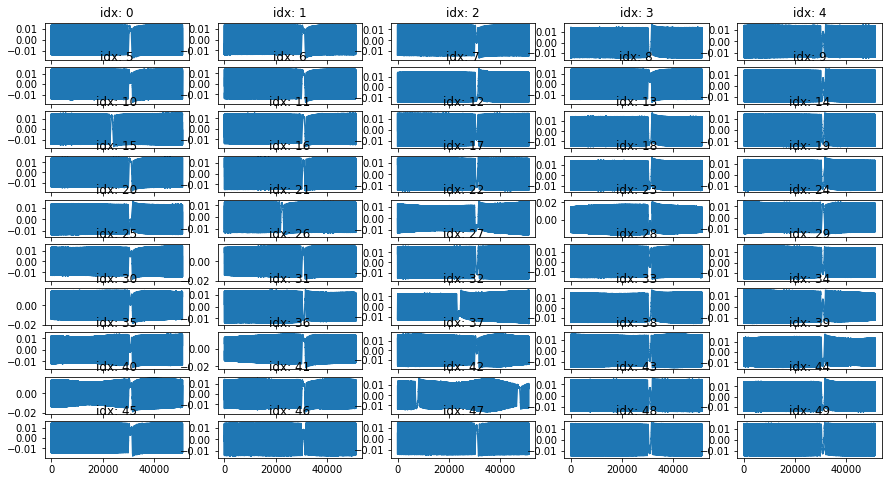

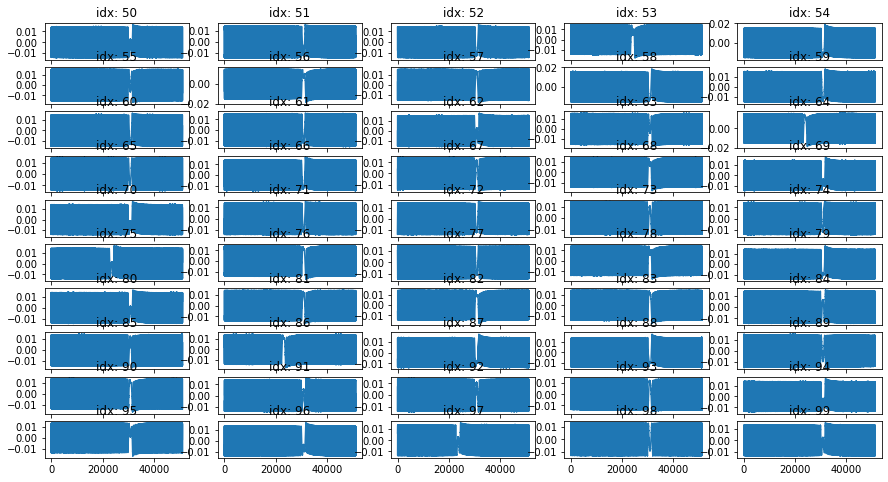

In [15]:
# tar_symbols = _rm_symbols
tar_symbols = filtered_symbols
# tar_symbols = sym.data

batch_size, stop_limit = 50, 8
batches = len(tar_symbols) // batch_size
print(f'batches = {batches}')

stop = 0

for epoch in range(len(tar_symbols) // batch_size):
    rows, cols = 10, 5
    fig, ax = plt.subplots(10, 5, figsize=(15, 8))
    
    for i in range(rows):
        for j in range(cols):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                idx = (epoch * rows * cols) + (cols * i) + j 
                if idx >= len(tar_symbols):
                    break
                ax[i, j].plot(tar_symbols[idx])
                ax[i, j].set_title(f'idx: {idx}')
            
    stop += 1
    if stop > stop_limit:
        break
    

# old dev

## setup

In [ ]:
file = symloader.filter(bw=9, sf=11, att=40)[0]
display(file)
file.load()

pfile = _load_matching_dotp(file.bw, file.sf)
display(pfile)

base_symbol = pfile.to_signal()
display(base_symbol)

In [ ]:
filtered_symbols, conv_vals = filter_symbols(file, thresh_type='quant', plot=False)

In [ ]:
bad_symbols = np.vstack([
    filtered_symbols[15],
    filtered_symbols[16],
    filtered_symbols[20],
    filtered_symbols[99],
    filtered_symbols[100],
    filtered_symbols[101],
    filtered_symbols[110],
    filtered_symbols[111],
])

good_symbols = np.vstack([
    filtered_symbols[0],
    filtered_symbols[5],
    filtered_symbols[8],
    filtered_symbols[71],
    filtered_symbols[1],
    filtered_symbols[3],
    filtered_symbols[29],
    filtered_symbols[30],
])

In [ ]:
plt.plot(conv_vals)

## bad symbol location

In [ ]:
for sym in filtered_symbols[10:20]:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        plt.figure(figsize=(5,1))
        plt.plot(sym)

In [ ]:
sym_df = (
    pd.DataFrame({'good': good_symbol, 'bad': bad_symbol})
    .assign(
        good_abs = lambda df: np.abs(df.good),
        bad_abs = lambda df: np.abs(df.bad),
    )
)
sym_df.head()

## metric exploration

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0].plot(good_symbols[0])
    ax[1].plot(bad_symbols[1])

## convolution

In [ ]:
import scipy as sp
import scipy.stats as spstats
import scipy.signal as spsig

In [ ]:
def _fft_convolve_autocorr(symbol: np.ndarray):
    return spsig.fftconvolve(symbol, symbol[::-1], mode='full')

def _sp_corr(base_symbol: np.ndarray, packet_slice: np.ndarray) -> float:
    min_size = np.min((base_symbol.size, packet_slice.size))
    corr = spsig.correlate(base_symbol, packet_slice)
    return np.abs(corr.max())
    

In [ ]:
good_fftconvs = np.vstack([
    _fft_convolve_autocorr(sym)
    for sym in good_symbols
])

bad_fftconvs = np.vstack([
    _fft_convolve_autocorr(sym)
    for sym in bad_symbols
])

In [ ]:
corr_vals = np.array([
    _sp_corr(base_symbol.data, fftconv)
    for fftconv in np.vstack([good_fftconvs, bad_fftconvs])
])

In [ ]:
_fftconvs = np.vstack([
    _sp_corr(base_symbol.data, _fft_convolve_autocorr(sym))
    for sym in np.vstack([good_symbols, bad_symbols])
])

In [ ]:
corr_vals = np.array([
    _sp_corr(base_symbol.data, fftconv)
    for fftconv in np.vstack([good_fftconvs, bad_fftconvs])
])

In [ ]:
plt.plot(sorted(corr_vals))

In [ ]:
filtered_symbols = [
    sym for sym, corr in zip(np.vstack([good_symbols,bad_symbols]), corr_vals)
    if corr > corr_vals.mean()
]

In [ ]:
len(filtered_symbols)

In [ ]:
idx = 0

In [ ]:
logger.warning(f'\n idx = {idx} '.center(60, '='))

good_fft_corr = _compute_corrcoefs(base_symbol.data, good_fftconvs[idx])
bad_fft_corr = _compute_corrcoefs(base_symbol.data, bad_fftconvs[idx])
good_sp_corr = _sp_corr(base_symbol.data, good_fftconvs[idx])
bad_sp_corr = _sp_corr(base_symbol.data, bad_fftconvs[idx])


fig, ax = plt.subplots(2, 2, figsize=(12, 6))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0,0].plot(good_symbols[idx])
    ax[0,1].plot(bad_symbols[idx])
    ax[1,0].plot(good_fftconvs[idx])
    ax[1,0].set_xlabel(f'good corr: {good_sp_corr:0.6f}')
    ax[1,1].plot(bad_fftconvs[idx])
    ax[1,1].set_xlabel(f'bad corr: {bad_sp_corr:0.6f}')
    

idx += 1

## correlation

In [ ]:
def _compute_corrcoefs(base_symbol: np.ndarray, packet_slice: np.ndarray) -> float:
    min_size = np.min((base_symbol.size, packet_slice.size))

    return np.real(np.abs(
        np.corrcoef(base_symbol[:min_size], packet_slice[:min_size])[0, 1]
    ))

In [ ]:
def _sp_corr(base_symbol: np.ndarray, packet_slice: np.ndarray) -> float:
    min_size = np.min((base_symbol.size, packet_slice.size))
    corr = spsig.correlate(base_symbol, packet_slice)
    return np.abs(corr.max())
    

In [ ]:
good_sp_corr = spsig.correlate(base_symbol.data, good_fftconvs[0])
bad_sp_corr = spsig.correlate(base_symbol.data, bad_fftconvs[0])

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0].plot(good_sp_corr)
    ax[1].plot(bad_sp_corr)

In [ ]:
_compute_corrcoefs(base_symbol.data, good_fftconv), _compute_corrcoefs(base_symbol.data, bad_fftconv)